# Imports

In [1]:
# local imports
from scripts.data import generate_random_simulation, generate_features, SimulationData, save_result, load_result
from scripts.nn import create_autoencoder_model, train_encoder, train_encoder_with_constraints
from scripts.loss import recovery_loss, fixed_points_loss, subsequent_distances_loss, angle_differences_loss
from scripts.visualization import plot_loss_evolution, plot_multiloss_evolution, plot_embedding,plot_embedding_on_simulation, plot_embedding_pca

# pytorch
import torch
from torch.optim import Adam
from torch import nn
from torch.nn.functional import mse_loss

# data manipulation
import numpy as np
from os.path import join, exists
from os import mkdir
from scipy.spatial.distance import pdist, squareform
from sklearn.decomposition import PCA
from itertools import chain

# visualization
from matplotlib import pyplot as plt
import seaborn

# Setup

In [2]:
N_STEPS = 200
N_SIMULATIONS = 200
MIN_X, MAX_X = [-10, 10]
MIN_Y, MAX_Y = [-10, 10]
N_ANCHORS = 5

In [3]:
DATA_PATH = 'data/'
simulations_file_name = join(DATA_PATH, 'generated_simulations.pt')
anchors_file_name = join(DATA_PATH, 'anchors_pos.pt')

#### generate data

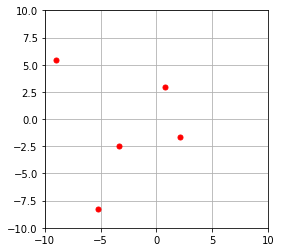

In [4]:
anchors_pos = torch.stack((
    MIN_X + (MAX_X - MIN_X) * torch.rand(N_ANCHORS),
    MIN_Y + (MAX_Y - MIN_Y) * torch.rand(N_ANCHORS)
), 1)

plt.figure(figsize=(4,4))
plt.plot(*anchors_pos.T, '.r', markersize=10)
plt.xlim([MIN_X, MAX_X])
plt.ylim([MIN_Y, MAX_Y])
plt.grid(True);

In [22]:
simulations = torch.stack([
    generate_random_simulation(MIN_X, MAX_X, MIN_Y, MAX_Y, N_STEPS)
for i in range(N_SIMULATIONS)])

#### save data

In [27]:
torch.save(simulations, simulations_file_name)
torch.save(anchors_pos, anchors_file_name)

#### load data 

In [4]:
simulations = torch.load(simulations_file_name)
anchors_pos = torch.load(anchors_file_name)

---

In [5]:
data = SimulationData(simulations, anchors_pos)

---

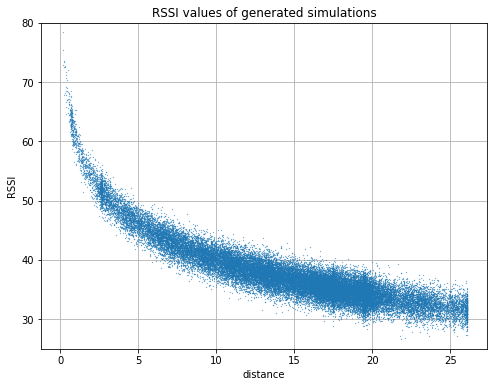

In [6]:
plt.figure(figsize=(8,6))
plt.grid()
plt.xlabel('distance')
plt.ylabel('RSSI')
plt.ylim([25, 80])
plt.title('RSSI values of generated simulations')
plt.plot(data.distances[:,:,0].flatten(), data.features[:,:,0].flatten(), '.', markersize=0.5)

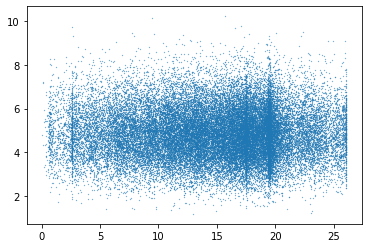

In [7]:
plt.plot(data.distances[:,:,0].flatten(), data.features[:,:,5].flatten(), '.', markersize=0.5)

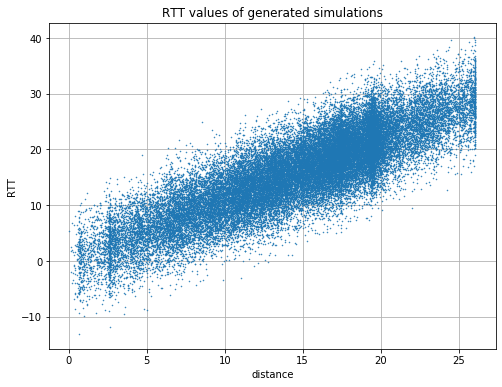

In [8]:
plt.figure(figsize=(8,6))
plt.grid()
plt.xlabel('distance')
plt.ylabel('RTT')
plt.title('RTT values of generated simulations')
plt.plot(data.distances[:,:,0].flatten(), data.features[:,:,10].flatten(), '.', markersize=1)

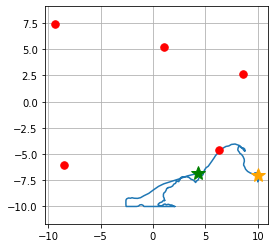

In [9]:
plt.figure(figsize=(4,4))
data.plot_simulation(data[0][1])

In [10]:
BATCH_SIZE = 1
N_EPOCHS = 500
train_loader, test_loader = data.get_random_loaders(0.8, BATCH_SIZE)

In [11]:
input_dim = 3 * N_ANCHORS

# Autoencoder

### Testing different embedding dimensions

Autoencoder with one hidden layer of 12 units

In [12]:
bot_dims = [2,3,4,5,6]
hid_dim = 12
n_dims = len(bot_dims)

Train autoencoder with bottleneck sizes of $[2,3,4,5,6]$

In [13]:
%%time

results = {}
for bot_dim in bot_dims:
    model = create_autoencoder_model(input_dim, hid_dim, bot_dim)
    
    train_loss, test_loss = train_encoder(model, train_loader, test_loader, N_EPOCHS)
    
    results[bot_dim] = {
        'model': model,
        'train_loss': train_loss,
        'test_loss': test_loss
    }

CPU times: user 4min 54s, sys: 6.15 s, total: 5min
Wall time: 5min 1s


In [14]:
# Save results
for bot_dim in bot_dims:
    results_name = f'autoencoder_{bot_dim}D_embedding'
    save_result(results[bot_dim], results_name)

In [15]:
# Load results
results = {}
for bot_dim in bot_dims:
    results_name = f'autoencoder_{bot_dim}D_embedding'
    results[bot_dim] = load_result(results_name, create_autoencoder_model(input_dim, hid_dim, bot_dim))

---

Train and test error for each embedding dimension

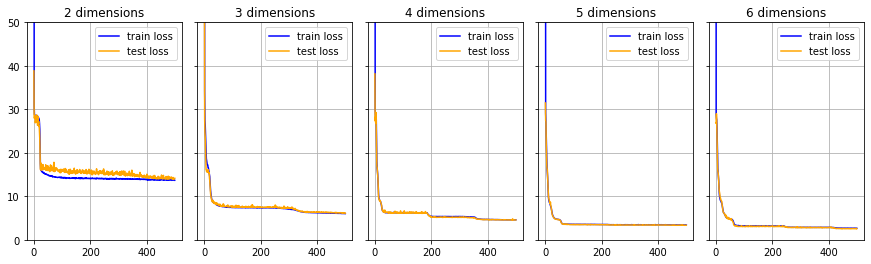

In [16]:
fig, ax = plt.subplots(nrows=(n_dims - 1) // 5 + 1, ncols=5, sharex=True, sharey=True, figsize=(15, 4))
plt.grid()
plt.subplots_adjust(wspace=0.1)

for i in range(n_dims):
    bot_dim = bot_dims[i]
    
    ax[i % 5].grid(True)
    ax[i % 5].plot(results[bot_dim]['train_loss'], c='blue')
    ax[i % 5].plot(results[bot_dim]['test_loss'], c='orange')
    ax[i % 5].legend(['train loss', 'test loss'])
    ax[i % 5].set_title(f'{bot_dim} dimensions')
    
plt.ylim(0, 50);

It looks like the 2 dimension model didn't converge yet.

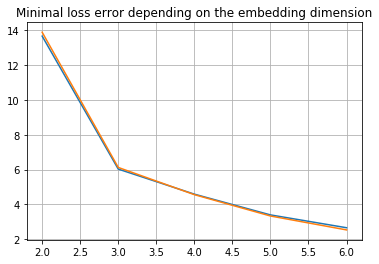

In [17]:
min_losses = {bot_dim: [min(results[bot_dim]['train_loss']), min(results[bot_dim]['test_loss'])] for bot_dim in bot_dims}

plt.title('Minimal loss error depending on the embedding dimension')
plt.grid(True)
plt.plot(bot_dims, [min_losses[bot_dim][0] for bot_dim in bot_dims])
plt.plot(bot_dims, [min_losses[bot_dim][1] for bot_dim in bot_dims]);

### 2-dimension embedding

Train an autoencoder with an embedding dimension of 2 for a longer time

In [18]:
%%time

model_2D = create_autoencoder_model(input_dim, hid_dim, bot_dim=2)

train_losses_2D, test_losses_2D = train_encoder(model_2D, train_loader, test_loader, 20 * N_EPOCHS)
result_2D = {
    'model': model_2D,
    'train_loss': train_losses_2D,
    'test_loss': test_losses_2D
}

CPU times: user 19min 16s, sys: 24.5 s, total: 19min 41s
Wall time: 19min 38s


In [19]:
# Save result
result_name = 'autoencoder_2D_embedding_long'
save_result(result_2D, result_name)

In [20]:
# Load result
result_name = 'autoencoder_2D_embedding_long'
result_2D = load_result(result_name, create_autoencoder_model(input_dim, hid_dim, 2))

---

Train and test loss of 2D embedding for longer time

(0, 25)

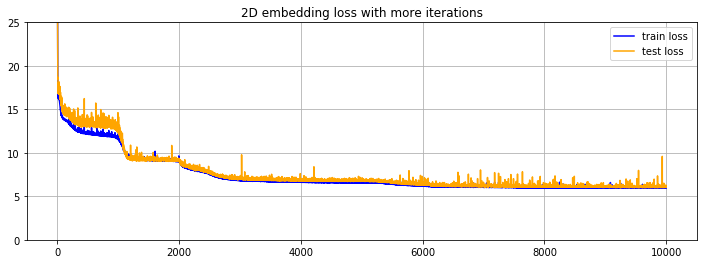

In [21]:
plt.figure(figsize=(12,4))
plt.title('2D embedding loss with more iterations')
plot_loss_evolution(result_2D['train_loss'], result_2D['test_loss'])
plt.ylim([0,25])

2D embedding plots

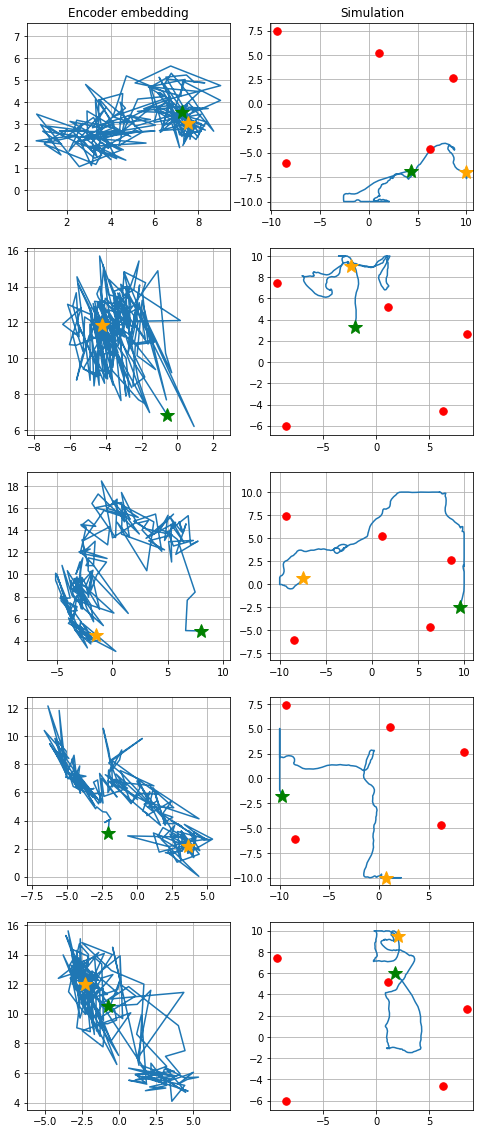

In [22]:
encoder, _ = result_2D['model']
plot_embedding(encoder, data, range(5))

#### Distance magnitude comparison

Compare if the distances magnitudes are proportional

In [23]:
encoded_data = encoder(data[:][0])
distance_matrix_input = pdist(data[2][0].view(-1, input_dim))
distance_matrix_encoded = pdist(encoded_data[2].view(-1, 2).detach())

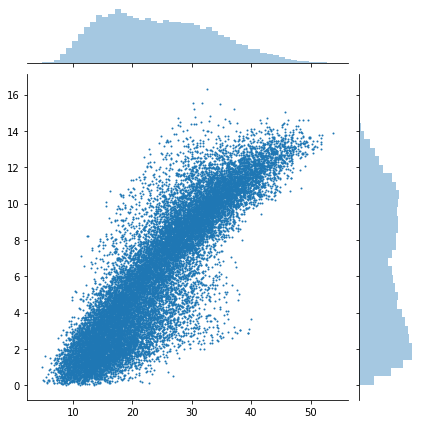

In [24]:
seaborn.jointplot(distance_matrix_input, distance_matrix_encoded, s=1)

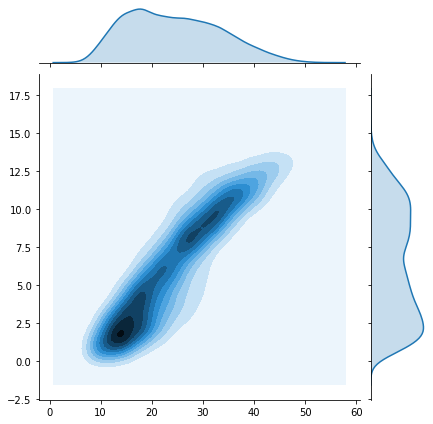

In [25]:
seaborn.jointplot(distance_matrix_input, distance_matrix_encoded, kind='kde')

### PCA

Try pca 2D embedding and compare with autoencoder

In [26]:
pca = PCA(n_components=2)
pca_2D_embedding = pca.fit_transform(data[:][0].view(-1, input_dim))

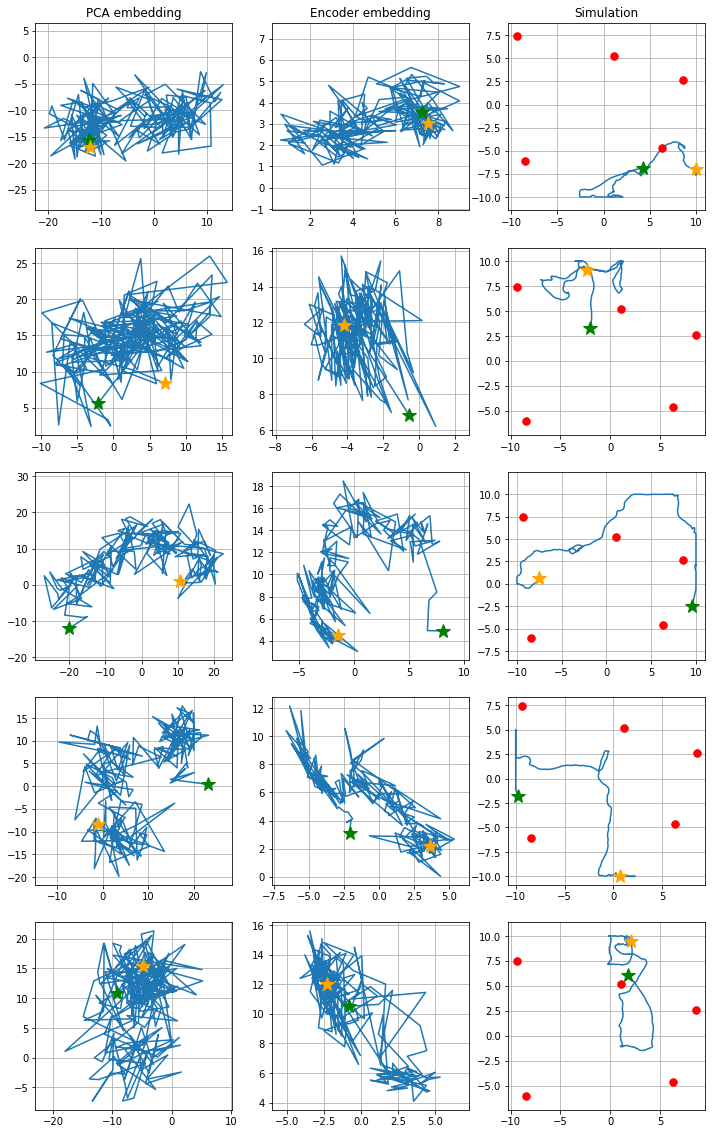

In [27]:
plot_embedding_pca(encoder, data, pca_2D_embedding.reshape((N_SIMULATIONS, N_STEPS, 2)), range(5))

In [28]:
pca_recovery_loss = mse_loss(data[:][0].view(N_SIMULATIONS * N_STEPS, input_dim), torch.FloatTensor(pca.inverse_transform(pca_2D_embedding)))
pca_recovery_loss

tensor(9.4159)

## Adding constraints

Add constraints as losses

#### With subsequent distance constraint

In [29]:
%%time

model_with_distance = create_autoencoder_model(input_dim, hid_dim, bot_dim=2)
loss_functions = [
    {
        'function': recovery_loss,
        'weight': 1.0
    }, {
        'function': subsequent_distances_loss,
        'weight': 10.0
    }
]

train_losses_with_distance, test_losses_with_distance = train_encoder_with_constraints(model_with_distance, train_loader, test_loader, 10 * N_EPOCHS, loss_functions)
result_with_distance = {
    'model': model_with_distance,
    'train_loss': train_losses_with_distance,
    'test_loss': test_losses_with_distance
}

CPU times: user 12min 49s, sys: 13.2 s, total: 13min 2s
Wall time: 13min 2s


In [30]:
# Save result
result_name = 'autoencoder_with_distance'
save_result(result_with_distance, result_name)

In [31]:
# Load result
result_name = 'autoencoder_with_distance'
result_with_distance = load_result(result_name, create_autoencoder_model(input_dim, hid_dim, bot_dim=2))

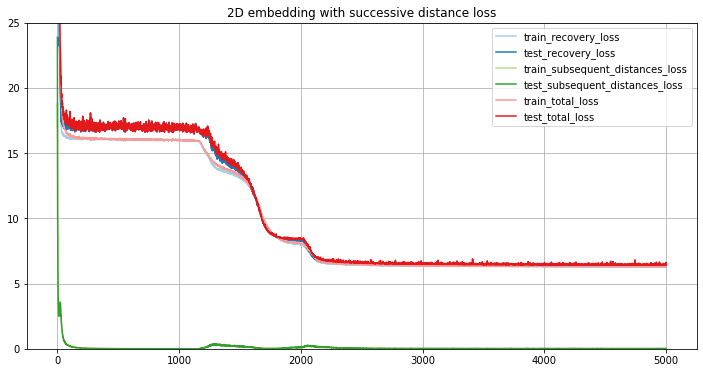

In [32]:
plot_multiloss_evolution(result_with_distance['train_loss'], result_with_distance['test_loss'])
plt.title('2D embedding with successive distance loss')
plt.ylim([0,25]);

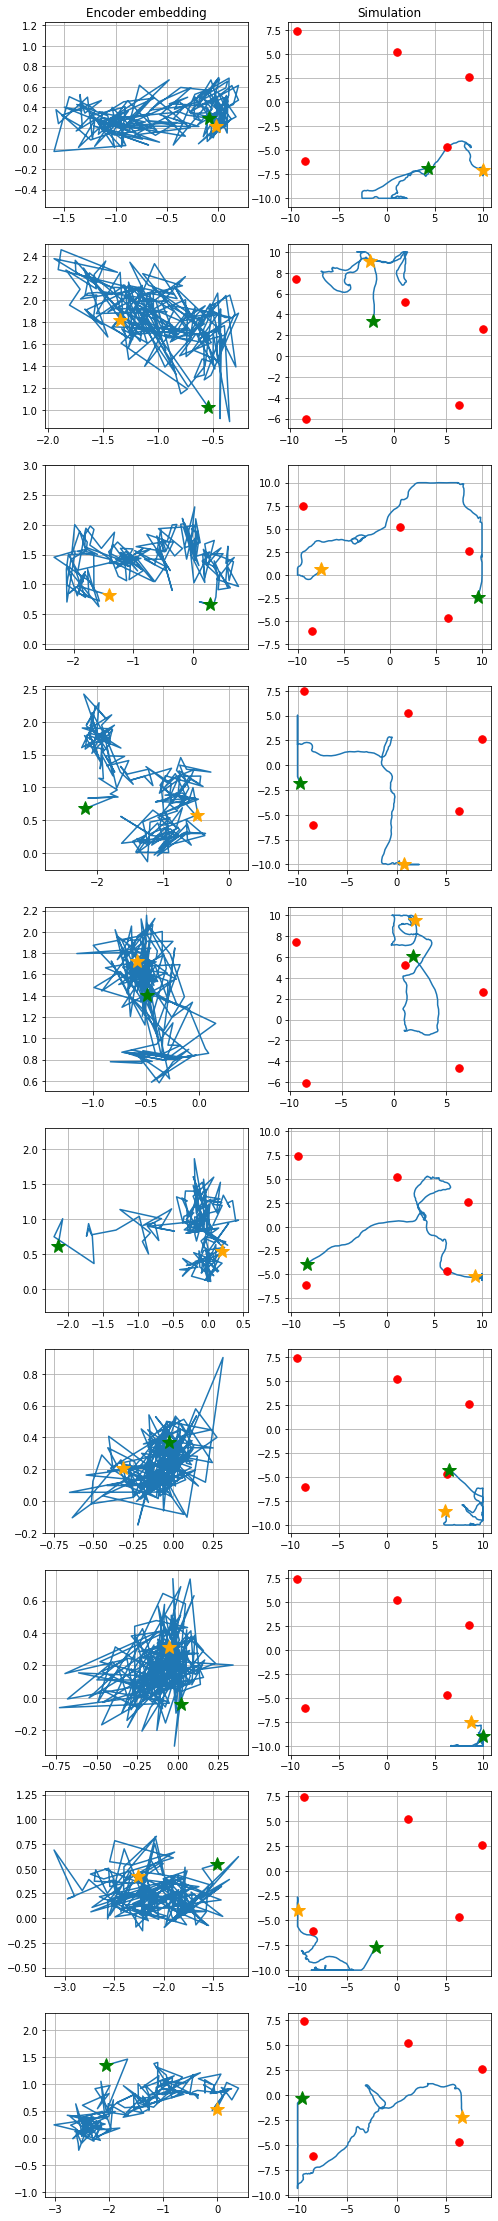

In [33]:
plot_embedding(result_with_distance['model'][0], data, range(10))

#### With fixed points

In [34]:
%%time

model_with_fixed_points = create_autoencoder_model(input_dim, hid_dim, bot_dim=2)
loss_functions = [
    {
        'function': recovery_loss,
        'weight': 1.0
    }, {
        'function': fixed_points_loss,
        'weight': 1.0
    }
]

train_losses_with_fixed_points, test_losses_with_fixed_points = train_encoder_with_constraints(model_with_fixed_points, train_loader, test_loader, 10 * N_EPOCHS, loss_functions)
result_with_fixed_points = {
    'model': model_with_fixed_points,
    'train_loss': train_losses_with_fixed_points,
    'test_loss': test_losses_with_fixed_points
}

CPU times: user 11min 16s, sys: 13.5 s, total: 11min 29s
Wall time: 11min 27s


In [35]:
# Save result
result_name = 'autoencoder_with_fixed_points'
save_result(result_with_fixed_points, result_name)

In [36]:
# Load result
result_name = 'autoencoder_with_fixed_points'
result_with_fixed_points = load_result(result_name, create_autoencoder_model(input_dim, hid_dim, bot_dim=2))

Text(0.5, 1.0, '2D embedding with fixed points loss')

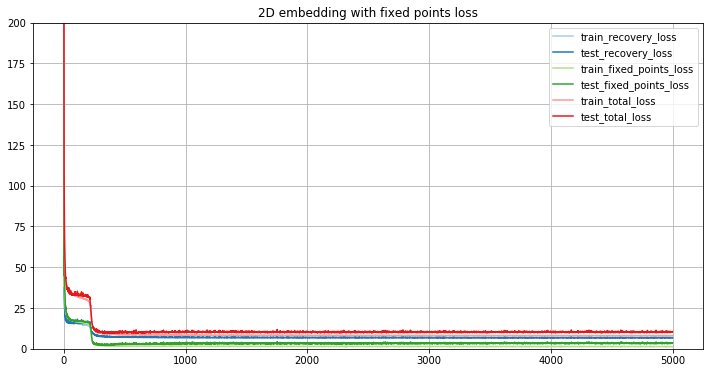

In [37]:
plot_multiloss_evolution(result_with_fixed_points['train_loss'], result_with_fixed_points['test_loss'])
plt.title('2D embedding with fixed points loss')

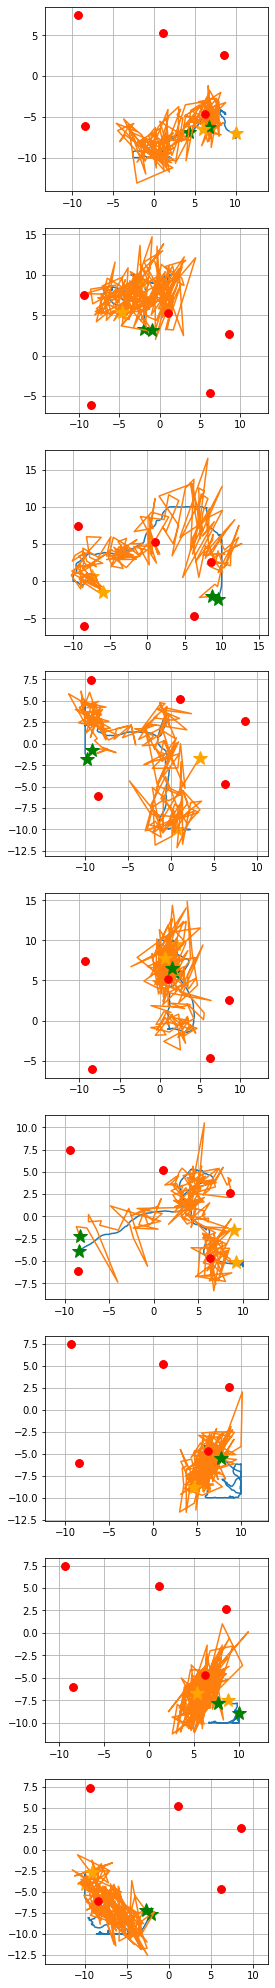

In [38]:
plot_embedding_on_simulation(result_with_fixed_points['model'][0], data, range(9))

#### With angles

In [39]:
%%time

model_with_angles = create_autoencoder_model(input_dim, hid_dim, bot_dim=2)
loss_functions = [
    {
        'function': recovery_loss,
        'weight': 1.0
    }, {
        'function': fixed_points_loss,
        'weight': 1.0
    }, {
        'function': angle_differences_loss,
        'weight': 10
    }
]

train_losses_with_angles, test_losses_with_angles = train_encoder_with_constraints(model_with_angles, train_loader, test_loader, 10 * N_EPOCHS, loss_functions)
result_with_angles = {
    'model': model_with_angles,
    'train_loss': train_losses_with_angles,
    'test_loss': test_losses_with_angles
}

CPU times: user 15min 12s, sys: 14.1 s, total: 15min 26s
Wall time: 15min 24s


In [40]:
# Save result
result_name = 'autoencoder_with_angles'
save_result(result_with_angles, result_name)

In [41]:
# Load result
result_name = 'autoencoder_with_angles'
result_with_angles = load_result(result_name, create_autoencoder_model(input_dim, hid_dim, 2))

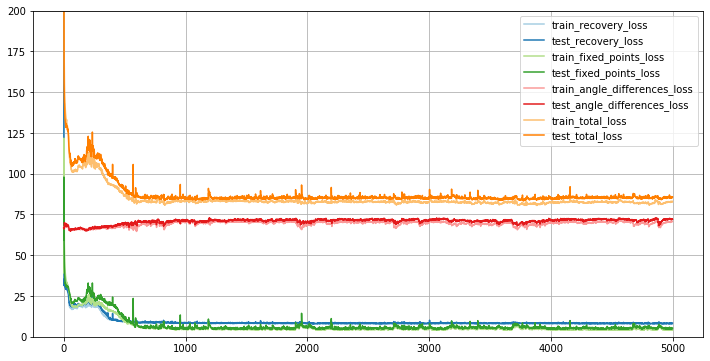

In [42]:
plot_multiloss_evolution(result_with_angles['train_loss'], result_with_angles['test_loss'])

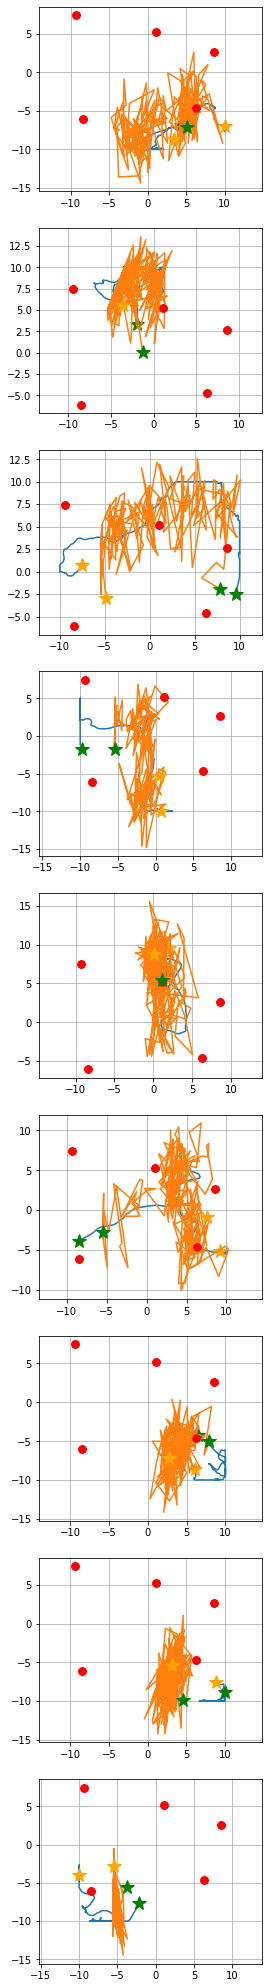

In [43]:
plot_embedding_on_simulation(result_with_angles['model'][0], data, range(9))

#### With all constraints

In [44]:
%%time

model_with_constraints = create_autoencoder_model(input_dim, hid_dim, bot_dim=2)
loss_functions = [
    {
        'function': recovery_loss,
        'weight': 1.0
    }, {
        'function': fixed_points_loss,
        'weight': 1.0
    }, {
        'function': subsequent_distances_loss,
        'weight': 10.0
    }
]

train_losses_with_constraints, test_losses_with_constraints = train_encoder_with_constraints(model_with_constraints, train_loader, test_loader, 10 * N_EPOCHS, loss_functions)
result_with_constraints = {
    'model': model_with_constraints,
    'train_loss': train_losses_with_constraints,
    'test_loss': test_losses_with_constraints
}

CPU times: user 13min 22s, sys: 13.6 s, total: 13min 35s
Wall time: 13min 33s


In [45]:
# Save result
result_name = 'autoencoder_with_constraints'
save_result(result_with_constraints, result_name)

In [46]:
# Load result
result_name = 'autoencoder_with_constraints'
result_with_constraints = load_result(result_name, create_autoencoder_model(input_dim, hid_dim, 2))

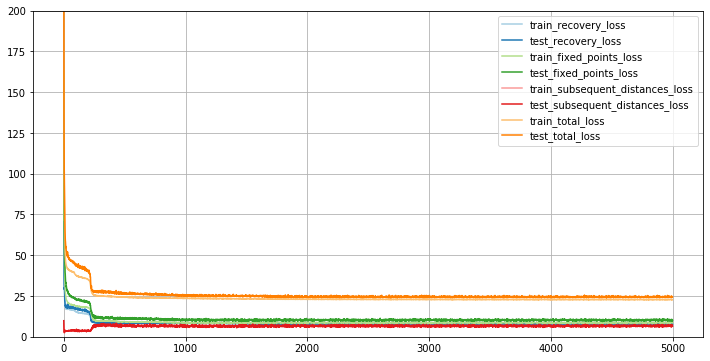

In [47]:
plot_multiloss_evolution(result_with_constraints['train_loss'], result_with_constraints['test_loss'])

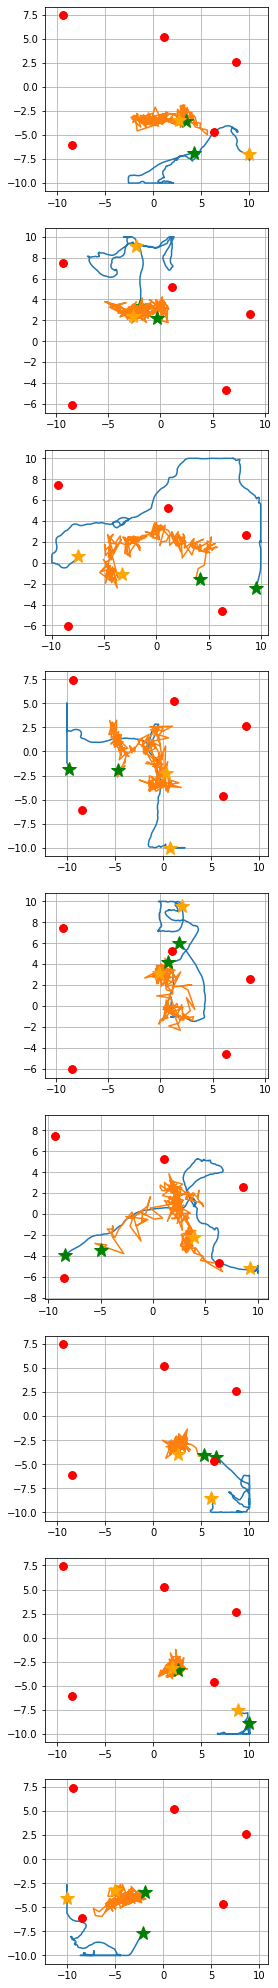

In [48]:
plot_embedding_on_simulation(result_with_constraints['model'][0], data, range(9))